In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq.chat_models import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.core.display import Markdown
from langchain_core.runnables import RunnableParallel
from langchain_core.messages import HumanMessage, AIMessage
import warnings

warnings.filterwarnings("ignore")
load_dotenv(find_dotenv())

USER_AGENT environment variable not set, consider setting it to identify your requests.
/home/trung/.conda/envs/rag_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


True

In [2]:
GROQ_API_KEY = os.getenv("GROQQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]=LANGCHAIN_API_KEY
os.environ["LANGCHAIN_PROJECT"]="advanced-rag"
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

- load nội dung 4 trang web tạo thành docs

In [3]:
urls = [
    "https://www.webmd.com/a-to-z-guides/malaria",
    "https://www.webmd.com/diabetes/type-1-diabetes",
    "https://www.webmd.com/diabetes/type-2-diabetes",
    "https://www.webmd.com/migraines-headaches/migraines-headaches-migraines",
]

loader = WebBaseLoader(urls, bs_get_text_kwargs={"strip": True})
docs = loader.load()

- split docs và tạo thành các chunks, sau đó dùng embedding + chroma để tổ chức index và trạo retrieval.

In [ ]:
docs

[Document(metadata={'source': 'https://www.webmd.com/a-to-z-guides/malaria', 'title': 'Malaria: Causes, Symptoms, and Treatment', 'description': 'Malaria can be serious and sometimes life-threatening. Learn more about the disease and its new vaccine.', 'language': 'en'}, page_content='Malaria: Causes, Symptoms, and TreatmentSkip to main contentHomeConditionsBackConditionsView AllADD/ADHDAllergiesArthritisAtrial fibrillationBreast CancerCancerCrohn\'s DiseaseDepressionDiabetesDVTEczemaEye HealthHeart DiseaseHIV & AIDSLung DiseaseLupusMental HealthMultiple SclerosisMigrainePain ManagementPsoriasisPsoriatic ArthritisRheumatoid ArthritisSexual ConditionsSkin ProblemsSleep DisordersUlcerative ColitisView AllDrugs & SupplementsBackDrugs & SupplementsDrugsSupplementsPill IdentifierInteraction CheckerWell-BeingBackWell-BeingAging WellBabyBirth ControlChildren\'s HealthDiet & Weight ManagementFitness & ExerciseFood & RecipesHealth & BalanceHealthy BeautyMen\'s HealthParentingPet HealthPregnancy

In [5]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
chunks = text_splitter.split_documents(docs)

embedding_function = HuggingFaceEmbeddings()

vector_store = Chroma.from_documents(documents=chunks, embedding=embedding_function)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [6]:
retriever.get_relevant_documents("Symptoms of migraine")

[Document(metadata={'description': 'Migraine headaches, also known as migraines, are a type of headache that can cause debilitating pain. Learn more about the types, causes, symptoms, diagnosis, & treatment of migraines.', 'language': 'en', 'source': 'https://www.webmd.com/migraines-headaches/migraines-headaches-migraines', 'title': 'Migraine: Symptoms, Causes, and Treatment'}, page_content='This pain may:Begin as a dull ache and then become throbbingGet worse duringphysical activityAffect one sideof your head or move from one side to the other, be in the front of your head, or affect your entire headDuring the headache, you may also:Have nausea (About 80% of people with migraine do, and about half vomit.)Be paleand clammyFeelfaintordizzyHave neck pain or stiffnessFeel anxious or depressedHave a runny nose or feel stuffed upBe sensitive to light(Noise or odors might also bother'),
 Document(metadata={'description': 'Migraine headaches, also known as migraines, are a type of headache th

- tạo ra 2 route về tìm kiếm docs trên web hay là tìm kiếm trong vectorStore
- đưa vào một câu query thì nó sẽ đi qua hàm bind_tools để thu được kết quả route nào phù hợp

In [7]:
class VectorStore(BaseModel):
    (
        "A vectorstore contains information about symptoms, treatment"
        ", risk factors and other information about malaria, type 1 and"
        "type 2 diabetes and migraines"
    )

    query: str


class SearchEngine(BaseModel):
    """A search engine for searching other medical information on the web"""

    query: str


router_prompt_template = (
    "You are an expert in routing user queries to either a VectorStore, SearchEngine\n"
    "Use SearchEngine for all other medical queries that are not related to malaria, diabetes, or migraines.\n"
    "The VectorStore contains information on malaria, diabetes, and migraines.\n"
    'Note that if a query is not medically-related, you must output "not medically-related", don\'t try to use any tool.\n\n'
    "query: {query}"
)

llm = ChatGroq(model="llama3-70b-8192", temperature=0)
prompt = ChatPromptTemplate.from_template(router_prompt_template)
question_router = prompt | llm.bind_tools(tools=[VectorStore, SearchEngine])

In [8]:
response = question_router.invoke("What are the symptoms of chest pain?")
"tool_calls" in response.additional_kwargs

True

- cụ thể ở đây nó sử dụng WebEngine

In [9]:
print(response)

content='' additional_kwargs={'tool_calls': [{'id': 'call_en09', 'function': {'arguments': '{"query":"chest pain symptoms"}', 'name': 'SearchEngine'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 1110, 'total_tokens': 1155, 'completion_time': 0.137031012, 'prompt_time': 0.054377937, 'queue_time': 0.022188265999999998, 'total_time': 0.191408949}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2f30b0b571', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-415bebce-eff9-4781-b3e5-63a114e5b135-0' tool_calls=[{'name': 'SearchEngine', 'args': {'query': 'chest pain symptoms'}, 'id': 'call_en09', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1110, 'output_tokens': 45, 'total_tokens': 1155}


- question và docs được kiểm tra xem có relevant hay irrelevant

In [10]:
from langchain_core.pydantic_v1 import validator

class Grader(BaseModel):
    "Use this format to give a binary score for relevance check on retrived documents."

    grade: Literal["relevant", "irrelevant"] = Field(
        ...,
        description="The relevance score for the document.\n"
        "Set this to 'relevant' if the given context is relevant to the user's query, or 'irrlevant' if the document is not relevant.",
    )

    @validator("grade", pre=True)
    def validate_grade(cls, value):
        if value == "not relevant":
            return "irrelevant"
        return value


grader_system_prompt_template = """"You are a grader tasked with assessing the relevance of a given context to a query. 
    If the context is relevant to the query, score it as "relevant". Otherwise, give "irrelevant".
    Do not answer the actual answer, just provide the grade in JSON format with "grade" as the key, without any additional explanation."
    """

grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grader_system_prompt_template),
        ("human", "context: {context}\n\nquery: {query}"),
    ]
)


grader_chain = grader_prompt | llm.with_structured_output(Grader, method="json_mode")

query = "symptoms of migraine"
context = retriever.get_relevant_documents(query)

response = grader_chain.invoke({"query": query, "context": context})

In [11]:
print(response)

grade='relevant'


In [12]:
query = "Treatment of Ulcer"
context = retriever.get_relevant_documents(query)

response = grader_chain.invoke({"query": query, "context": context})
print(response)

grade='irrelevant'


- trả lời dựa trên docs liên quan

In [13]:
rag_template_str = (
    "You are a helpful assistant. Answer the query below based only on the provided context.\n\n"
    "context: {context}\n\n"
    "query: {query}"
)


rag_prompt = ChatPromptTemplate.from_template(rag_template_str)
rag_chain = rag_prompt | llm | StrOutputParser()

query = "What are the symptoms of malaria?"
context = retriever.get_relevant_documents(query)

response = rag_chain.invoke({"query": query, "context": context})

Markdown(response)

Based on the provided context, the symptoms of malaria include:

* Impaired consciousness
* Convulsions
* Difficulty breathing
* Serious tiredness and fatigue
* Dark or bloody urine
* Yellow eyes and skin (jaundice)
* Abnormal bleeding
* Very tired (fatigue)
* Body aches
* Yellow skin (jaundice)
* Kidney failure
* Seizure
* Confusion
* Bloody stools
* Convulsions
* Death
* High fever
* Chills
* Sweating
* Nausea or vomiting
* Headache
* Diarrhea
* Being very tired

Note that some of these symptoms may be similar to those of a cold or flu, and it's important to seek medical care as soon as possible if you suspect you may have malaria.

In [14]:
fallback_prompt = ChatPromptTemplate.from_template(
    (
        "You are a friendly medical assistant created by NHVAI.\n"
        "Do not respond to queries that are not related to health.\n"
        "If a query is not related to health, acknowledge your limitations.\n"
        "Provide concise responses to only medically-related queries.\n\n"
        "Current conversations:\n\n{chat_history}\n\n"
        "human: {query}"
    )
)

fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                (
                    f"human: {msg.content}"
                    if isinstance(msg, HumanMessage)
                    else f"AI: {msg.content}"
                )
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query") ,
    }
    | fallback_prompt
    | llm
    | StrOutputParser()
)

fallback_chain.invoke(
    {
        "query": "Hello",
        "chat_history": [],
    }
)

"Hello! I'm happy to help with any health-related questions or concerns you may have. How can I assist you today?"

- đánh giá câu trả lời có dựa trên docs hay không

In [15]:
class HallucinationGrader(BaseModel):
    "Binary score for hallucination check in llm's response"

    grade: Literal["yes", "no"] = Field(
        ..., description="'yes' if the llm's reponse is hallucinated otherwise 'no'"
    )


hallucination_grader_system_prompt_template = (
    "You are a grader assessing whether a response from an llm is based on a given context.\n"
    "If the llm's response is not based on the given context give a score of 'yes' meaning it's a hallucination"
    "otherwise give 'no'\n"
    "Just give the grade in json with 'grade' as a key and a binary value of 'yes' or 'no' without additional explanation"
)

hallucination_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_grader_system_prompt_template),
        ("human", "context: {context}\n\nllm's response: {response}"),
    ]
)


hallucination_grader_chain = (
    RunnableParallel(
        {
            "response": itemgetter("response"),
            "context": lambda x: "\n\n".join([c.page_content for c in x["context"]]),
        }
    )
    | hallucination_grader_prompt
    | llm.with_structured_output(HallucinationGrader, method="json_mode")
)

query = "Symptoms of malaria"
context = retriever.get_relevant_documents(query)
response = """Based on the context provided, the symptoms of malaria include: Impaired consciousness, Convulsions, Difficulty breathing,
Serious tiredness and fatigue, Dark or bloody urine, Yellow eyes and skin (jaundice), Abnormal bleeding, High fever, Chills,
Sweating, Nausea or vomiting, Headache, Diarrhea"""

response = hallucination_grader_chain.invoke({"response": response, "context": context})

In [16]:
response

HallucinationGrader(grade='no')

In [17]:
class AnswerGrader(BaseModel):
    "Binary score for an answer check based on a query."

    grade: Literal["yes", "no"] = Field(
        ...,
        description="'yes' if the provided answer is an actual answer to the query otherwise 'no'",
    )


answer_grader_system_prompt_template = (
    "You are a grader assessing whether a provided answer is in fact an answer to the given query.\n"
    "If the provided answer does not answer the query give a score of 'no' otherwise give 'yes'\n"
    "Just give the grade in json with 'grade' as a key and a binary value of 'yes' or 'no' without additional explanation"
)

answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_system_prompt_template),
        ("human", "query: {query}\n\nanswer: {response}"),
    ]
)


answer_grader_chain = answer_grader_prompt | llm.with_structured_output(
    AnswerGrader, method="json_mode"
)

query = "Symptoms of malaria"
# context = retriever.get_relevant_documents(query)
response = """Based on the context provided, the symptoms of malaria include: Impaired consciousness, Convulsions, Difficulty breathing,
Serious tiredness and fatigue, Dark or bloody urine, Yellow eyes and skin (jaundice), Abnormal bleeding, High fever, Chills,
Sweating, Nausea or vomiting, Headache, Diarrhea"""

response = answer_grader_chain.invoke({"response": response, "query": query})

In [18]:
response

AnswerGrader(grade='yes')

In [19]:
from typing import TypedDict
from langchain_core.documents import Document
from langgraph.prebuilt import ToolExecutor
from langchain_core.tools import Tool
from langchain_core.messages.base import BaseMessage

tavily_search = TavilySearchResults()
tool_executor = ToolExecutor(
    tools=[
        Tool(
            name="VectorStore",
            func=retriever.invoke,
            description="Useful to search the vector database",
        ),
        Tool(
            name="SearchEngine", func=tavily_search, description="Useful to search the web"
        ),
    ]
)


class AgentSate(TypedDict):
    """The dictionary keeps track of the data required by the various nodes in the graph"""

    query: str
    chat_history:list[BaseMessage]
    generation: str
    documents: list[Document]


def retrieve_node(state: dict) -> dict[str, list[Document] | str]:
    """
    Retrieve relevent documents from the vectorstore

    query: str

    return list[Document]
    """
    query = state["query"]
    documents = retriever.invoke(input=query)
    return {"documents": documents}


def fallback_node(state: dict):
    """
    Fallback to this node when there is no tool call
    """
    query = state["query"]
    chat_history = state["chat_history"]
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    return {"generation": generation, "documents": []}


def filter_documents_node(state: dict):
    filtered_docs = list()

    query = state["query"]
    documents = state["documents"]
    for i, doc in enumerate(documents, start=1):
        grade = grader_chain.invoke({"query": query, "context": doc})
        if grade.grade == "relevant":
            print(f"---CHUCK {i}: RELEVANT---")
            filtered_docs.append(doc)
        else:
            print(f"---CHUCK {i}: NOT RELEVANT---")
    return {"documents": filtered_docs}


def rag_node(state: dict):
    query = state["query"]
    documents = state["documents"]

    generation = rag_chain.invoke({"query": query, "context": documents})
    return {"generation": generation}


def web_search_node(state: dict):
    query = state["query"]
    results = tavily_search.invoke(query)
    documents = [
        Document(page_content=doc["content"], metadata={"source": doc["url"]})
        for doc in results
    ]
    return {"documents": documents}


def question_router_node(state: dict):
    query = state["query"]
    try:
        response = question_router.invoke({"query": query})
    except Exception:
        return "llm_fallback"

    if "tool_calls" not in response.additional_kwargs:
        print("---No tool called---")
        return "llm_fallback"

    if len(response.additional_kwargs["tool_calls"]) == 0:
        raise "Router could not decide route!"

    route = response.additional_kwargs["tool_calls"][0]["function"]["name"]
    if route == "VectorStore":
        print("---Routing to VectorStore---")
        return "VectorStore"
    elif route == "SearchEngine":
        print("---Routing to SearchEngine---")
        return "SearchEngine"


def should_generate(state: dict):
    filtered_docs = state["documents"]

    if not filtered_docs:
        print("---All retrived documents not relevant---")
        return "SearchEngine"
    else:
        print("---Some retrived documents are relevant---")
        return "generate"


def hallucination_and_answer_relevance_check(state: dict):
    llm_response = state["generation"]
    documents = state["documents"]
    query = state["query"]

    hallucination_grade = hallucination_grader_chain.invoke(
        {"response": llm_response, "context": documents}
    )
    if hallucination_grade.grade == "no":
        print("---Hallucination check passed---")
        answer_relevance_grade = answer_grader_chain.invoke(
            {"response": llm_response, "query": query}
        )
        if answer_relevance_grade.grade == "yes":
            print("---Answer is relevant to question---\n")
            return "useful"
        else:
            print("---Answer is not relevant to question---")
            return "not useful"
    print("---Hallucination check failed---")
    return "generate"

In [20]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentSate)
workflow.add_node("VectorStore", retrieve_node)
workflow.add_node("SearchEngine", web_search_node)
workflow.add_node("filter_docs", filter_documents_node)
workflow.add_node("fallback", fallback_node)
workflow.add_node("rag", rag_node)

workflow.set_conditional_entry_point(
    question_router_node,
    {
        "llm_fallback": "fallback",
        "VectorStore": "VectorStore",
        "SearchEngine": "SearchEngine",
    },
)

workflow.add_edge("VectorStore", "filter_docs")
workflow.add_edge("SearchEngine", "filter_docs")
workflow.add_conditional_edges(
    "filter_docs", should_generate, {"SearchEngine": "SearchEngine", "generate": "rag"}
)
workflow.add_conditional_edges(
    "rag",
    hallucination_and_answer_relevance_check,
    {"useful": END, "not useful": "SearchEngine", "generate": "rag"},
)

workflow.add_edge("fallback", END)

In [21]:
app = workflow.compile(debug=False)
plot = app.get_graph().draw_mermaid_png()

with open("plot.png", "wb") as fp:
    fp.write(plot)

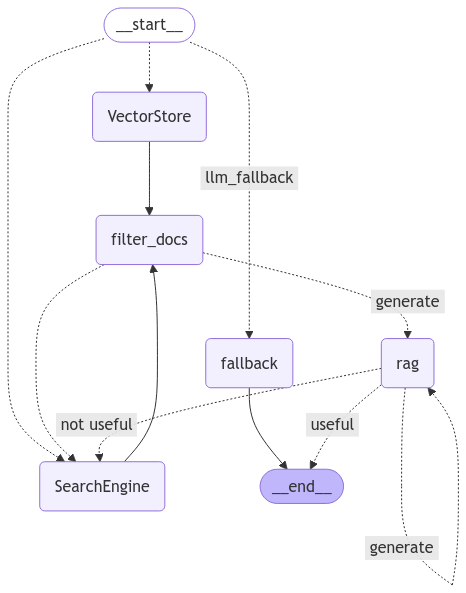

In [22]:
from io import BytesIO
from PIL import Image
from IPython.display import display

# Assuming you have the byte image stream in the 'byte_image' variable
img = Image.open(BytesIO(plot))
display(img)

In [23]:
for token in app.stream({"query": "What are the risk factors of migraines", "chat_history": []}):
    print(token, end="", flush=True)

---Routing to VectorStore---
{'VectorStore': {'documents': [Document(metadata={'description': 'Migraine headaches, also known as migraines, are a type of headache that can cause debilitating pain. Learn more about the types, causes, symptoms, diagnosis, & treatment of migraines.', 'language': 'en', 'source': 'https://www.webmd.com/migraines-headaches/migraines-headaches-migraines', 'title': 'Migraine: Symptoms, Causes, and Treatment'}, page_content="members who get them. If one parent has a history of thesetypes of headaches, you have a 50% chance of getting them. If both parents have them, the risk jumps to 75%.Other medical conditions.Depression,\xa0anxiety,bipolar disorder,sleep disorders, andepilepsycan raise your odds.Migraine TriggersSome things that may trigger an attack\xa0include:Hormone changes.You maynotice that you have headaches around your period, while you'repregnant, or when you'reovulating. Symptoms may also be tied to"), Document(metadata={'description': 'Migraine hea

In [24]:
# response = app.invoke({"query": "What are the symptoms of hypertension", "chat_history": []})
# Markdown(response["generation"])

In [25]:
# !pip install gradio

In [26]:
# import gradio as gr
# from uuid import uuid4

# history = {}
# session_id = str(uuid4())

# def chat(query):

#     # Initialize the chat history for the current session
#     if session_id not in history:
#         history[session_id] = []

#     chat_history = history[session_id]

#     # Invoke the app with the current query and chat history
#     result = app.invoke({"query": query, "chat_history": chat_history})

#     # Separate the response from the retrieved documents
#     response = result["generation"]
#     documents = result["documents"]

#     # Add the current exchange to the chat history
#     chat_history.extend([HumanMessage(content=query), AIMessage(content=response)])

#     if not documents:
#         return response, documents

#     documents = [
#         f"{doc.page_content}\nsource: {doc.metadata['source']}" for doc in documents
#     ]

#     return response, "\n\n".join(documents)

# # Create the Gradio interface
# demo = gr.Interface(
#     fn=chat,
#     inputs=gr.Textbox(label="Question"),
#     outputs=[gr.Textbox(label="Response"), gr.Textbox(label="Retrieved Documents")],
#     title="RAG Chatbot",
#     description="Ask a health-related query and the chatbot will generate a response using Retrieval Augmented Generation.",
# )

# if __name__ == "__main__":
#     demo.launch(share=True, inline=True)

In [27]:
from uuid import uuid4

history = {}
session_id = str(uuid4())

if session_id not in history:
    history[session_id] = []

chat_history = history[session_id]

while True:
    query = input("Bạn: ")
    
    if query.lower() == "exit":
        print("Thoát chương trình.")
        break

    # Gọi mô hình với câu hỏi và lịch sử hội thoại
    # try:
    print("chat_history", chat_history)
    result = app.invoke({"query": query, "chat_history": chat_history})
    
    # Tách câu trả lời và tài liệu truy xuất
    response = result["generation"]
    documents = result["documents"]
    # except Exception:
    #     print("Câu hỏi này không thuộc trong chủ đề về y tế. Hãy đặt câu hỏi khác.")
    #     continue

    # Lưu vào lịch sử hội thoại
    # chat_history.append({"human": query, "ai": response})
    chat_history.extend([HumanMessage(content=query), AIMessage(content=response)])

    print(f"AI: {response}")

    if documents:
        print("\nTài liệu liên quan:")
        for doc in documents:
            print(f"- {doc.page_content} (Nguồn: {doc.metadata['source']})")

    
    print("-" * 50)  # Dòng ngăn cách giữa các lần hỏi


Thoát chương trình.


In [28]:
contract_text = """
SERVICE AGREEMENT
This Service Agreement ("Agreement") is made and entered into on this 10th day of February 2025, by and between:

Company A ("Service Provider"), having its principal place of business at 123 Business Road, New York, NY 10001, USA.
Company B ("Client"), having its principal place of business at 456 Client Avenue, San Francisco, CA 94105, USA.
1. Scope of Services
The Service Provider agrees to provide software development and IT consulting services as per the requirements specified by the Client.

2. Term of Agreement
This Agreement shall commence on February 15, 2025, and shall remain in effect for a period of one (1) year, unless terminated earlier under the provisions of this Agreement.

3. Payment Terms
3.1. The Client agrees to pay the Service Provider a fixed monthly fee of $10,000 for the services rendered.
3.2. Payments shall be made within 30 days of receiving an invoice from the Service Provider.
3.3. Late payments will incur a penalty of 5% per month on the outstanding amount.

4. Confidentiality
Both parties agree to maintain confidentiality regarding any business, technical, or financial information disclosed during the term of this Agreement.

5. Termination
5.1. Either party may terminate this Agreement with 30 days' written notice to the other party.
5.2. If the Client terminates the Agreement before the one-year term is completed, a penalty fee of $20,000 shall be payable to the Service Provider.
5.3. Notwithstanding the above, the Client may terminate the Agreement at any time without penalty if the Service Provider fails to meet its service obligations for three consecutive months.

6. Governing Law
This Agreement shall be governed by and construed in accordance with the laws of the State of New York.

7. Dispute Resolution  
In case of any dispute arising from late payments as outlined in Section 3, both parties agree to attempt an amicable resolution through mediation before initiating any legal proceedings.
"""


In [29]:
# chia thành các chunks
import re

def split_contract_text(contract_text):
    sections = re.split(r'(?=\n\d+\.)', contract_text)
    title = "SERVICE AGREEMENT"
    # chunks = []
    dict_chunks = {}
    
    current_chunk = []
    
    for section in sections:
        section = section.strip()
        if section:
            if re.match(r'\d+\.', section) and not re.match(r'\d+\.\d+', section):
                if current_chunk:
                    print("current_chunk", current_chunk)
                    id_chunk = "section_" + current_chunk[0].split(".")[0]
                    if title not in current_chunk[0]:
                        # chunks.append(f"{title}\n" + "\n".join(current_chunk))
                        dict_chunks[id_chunk] = f"{title}\n" + "\n".join(current_chunk)
                    else:
                        # chunks.append("\n".join(current_chunk))
                        dict_chunks["section_0"] = "\n".join(current_chunk)
                    current_chunk = []
            current_chunk.append(section)
    
    if current_chunk:
        print("current_chunk", current_chunk)
        id_chunk = "section_" + current_chunk[0].split(".")[0]
        if title not in current_chunk[0]:
            # chunks.append(f"{title}\n" + "\n".join(current_chunk))
            dict_chunks[id_chunk] = f"{title}\n" + "\n".join(current_chunk)
        else:
            # chunks.append("\n".join(current_chunk))
            dict_chunks[id_chunk] = "\n".join(current_chunk)
    
    return dict_chunks

dict_chunks = split_contract_text(contract_text)
for key, value in dict_chunks.items():
    print(f"Chunk {key}:\n{value}\n{'-'*50}")

# chunks = split_contract_text(contract_text)
# for i, chunk in enumerate(chunks, 1):
#     print(f"Chunk {i}:\n{chunk}\n{'-'*50}")

current_chunk ['SERVICE AGREEMENT\nThis Service Agreement ("Agreement") is made and entered into on this 10th day of February 2025, by and between:\n\nCompany A ("Service Provider"), having its principal place of business at 123 Business Road, New York, NY 10001, USA.\nCompany B ("Client"), having its principal place of business at 456 Client Avenue, San Francisco, CA 94105, USA.']
current_chunk ['1. Scope of Services\nThe Service Provider agrees to provide software development and IT consulting services as per the requirements specified by the Client.']
current_chunk ['2. Term of Agreement\nThis Agreement shall commence on February 15, 2025, and shall remain in effect for a period of one (1) year, unless terminated earlier under the provisions of this Agreement.']
current_chunk ['3. Payment Terms', '3.1. The Client agrees to pay the Service Provider a fixed monthly fee of $10,000 for the services rendered.', '3.2. Payments shall be made within 30 days of receiving an invoice from the 

- chunk 7 nhắc trực tiếp đến chunk 3
- chunk 5.2 liên quan đến chunk 5.3 (trong cùng một chunk 5)
- chunk 2 liên quan đến chunk 5 (cụ thể là 5.1)

In [30]:
# kiểm tra xem chunk có nhắc trực tiếp đến chunk khác không?
### Mention Grader 

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq


# Data model
class GradeMentions(BaseModel):
    """id of the chunks referred to in the query."""
    list_id: list[str] = Field(description="List of chunk ids mentioned in the query, is [] if no chunk is mentioned")
    # binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatGroq(model="llama3-70b-8192", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeMentions)

# Prompt 
system = """You are the one who lists the ids of the chunks mentioned in the user's query. \n
If the query contains keywords that refer to other chunks, return a list of the ids mentioned in the query. Only list the ids that are mentioned, not the ids that are the query itself. \n
The output must be in lowercase format and have an _ in the middle. Otherwise, leave the array empty. \n
Example output: ['section_1, section_3']"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User query: {query}"),
    ]
)

mention_grader = grade_prompt | structured_llm_grader
query = """SERVICE AGREEMENT
7. Dispute Resolution  
In case of any dispute arising from late payments as outlined in Section 3, both parties agree to attempt an amicable resolution through mediation before initiating any legal proceedings."""
print(mention_grader.invoke({"query": query}))

list_id=['section_3']


In [31]:
query = """SERVICE AGREEMENT
2. Term of Agreement
This Agreement shall commence on February 15, 2025, and shall remain in effect for a period of one (1) year, unless terminated earlier under the provisions of this Agreement.
"""
print(mention_grader.invoke({"query": query}).list_id)

[]


In [32]:
mentions = {}

for key, value in dict_chunks.items():
    # print(f"Chunk {key}:\n{value}\n{'-'*50}")
    mentions[key] = mention_grader.invoke({"query": value}).list_id

for key, value in mentions.items():
    print(f"Chunk {key} mentions: {value}")

Chunk section_0 mentions: []
Chunk section_1 mentions: []
Chunk section_2 mentions: []
Chunk section_3 mentions: []
Chunk section_4 mentions: []
Chunk section_5 mentions: []
Chunk section_6 mentions: []
Chunk section_7 mentions: ['section_3']


In [ ]:
# kiểm tra liên quan trực tiếp đến nhau hay không?
### Contracts Grader 

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq


# Data model
class GradeContracts(BaseModel):
    """Binary score for relevance check on chunks in the contract."""

    binary_score: str = Field(description="Two chunks in the contract are relevant to each other, 'yes' or 'no'")
    explanation: str = Field(description="The short explanation is that the two related chunks are similar, conflict, or unrelated.")

# LLM with function call 
llm = ChatGroq(model="llama3-70b-8192", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeContracts)

# Prompt 
system = """You are the grader who evaluates the relevance of two different chunks in the user-supplied contract. \n
The goal is to find chunks that are closely related in the contract. \n
Chunks that are related in topic but not in content are considered unrelated. \n
If the two chunks are similar or contradictory, score them as relevant. If they refer to different issues in more or less the same way, score them as unrelated. \n
Give a binary 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_contract_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Chunk 1: \n\n {chunk_1} \n\n Chunk 2: {chunk_2}"),
    ]
)

contracts_grader = grade_contract_prompt | structured_llm_grader
chunk_1 = """SERVICE AGREEMENT
2. Term of Agreement
This Agreement shall commence on February 15, 2025, and shall remain in effect for a period of one (1) year, unless terminated earlier under the provisions of this Agreement."""
chunk_2 = """SERVICE AGREEMENT
5. Termination
5.1. Either party may terminate this Agreement with 30 days' written notice to the other party.
5.2. If the Client terminates the Agreement before the one-year term is completed, a penalty fee of $20,000 shall be payable to the Service Provider.
5.3. Notwithstanding the above, the Client may terminate the Agreement at any time without penalty if the Service Provider fails to meet its service obligations for three consecutive months."""
print(contracts_grader.invoke({"chunk_1": chunk_1, "chunk_2": chunk_2}))

binary_score='yes' explanation='The two chunks are related as they both discuss the termination of the service agreement, with one specifying the notice period and the other outlining the penalty fee and conditions for termination.'


In [56]:
# kiểm tra liên quan trực tiếp đến nhau hay không?
# 1 liên quan đến 2 thì 2 cũng liên quan đến 1 nên không cần lặp qua tất cả các cặp chunk
for i in range(len(dict_chunks)):
    for j in range(i + 1, len(dict_chunks)):
        chunk_1 = dict_chunks[f"section_{i}"]
        chunk_2 = dict_chunks[f"section_{j}"]
        # loại bỏ dòng đầu tiên vì nó chứa tiêu đề
        chunk_1 = chunk_1.split("\n", 1)[1]
        chunk_2 = chunk_2.split("\n", 1)[1]
        print(i, j)
        print(chunk_1, chunk_2)
        print(f"Chunk {i} and Chunk {j} relevance: {contracts_grader.invoke({'chunk_1': chunk_1, 'chunk_2': chunk_2})}")
# print(contracts_grader.invoke({"chunk_1": chunk_1, "chunk_2": chunk_2}))

0 1
This Service Agreement ("Agreement") is made and entered into on this 10th day of February 2025, by and between:

Company A ("Service Provider"), having its principal place of business at 123 Business Road, New York, NY 10001, USA.
Company B ("Client"), having its principal place of business at 456 Client Avenue, San Francisco, CA 94105, USA. 1. Scope of Services
The Service Provider agrees to provide software development and IT consulting services as per the requirements specified by the Client.
Chunk 0 and Chunk 1 relevance: binary_score='yes' explanation='The two chunks are related as they both describe the agreement between the Service Provider and the Client.'
0 2
This Service Agreement ("Agreement") is made and entered into on this 10th day of February 2025, by and between:

Company A ("Service Provider"), having its principal place of business at 123 Business Road, New York, NY 10001, USA.
Company B ("Client"), having its principal place of business at 456 Client Avenue, San

In [61]:
prompt_tem = """Here is my list of laws, I want to divide these laws into different groups, give me the names and descriptions of the groups that fit. Then put all 79 laws into those groups, no law should be missing.

[
    "平成十五年法律第五十七号　個人情報の保護に関する法律",
    "昭和二十二年法律第四十九号　労働基準法",
    "昭和三十四年法律第百四十一号　国民年金法",
    "平成十九年法律第百二十八号　労働契約法",
    "昭和二十五年法律第六十二号　退職職員に支給する退職手当支給の財源に充てるための特別会計からする一般会計への繰入れに関する法律",
    "昭和四十一年法律第百三十二号　労働施策の総合的な推進並びに労働者の雇用の安定及び職業生活の充実等に関する法律",
    "平成十四年法律第四十八号　地方公共団体の一般職の任期付職員の採用に関する法律",
    "昭和二十七年法律第九十三号　在外公館の名称及び位置並びに在外公館に勤務する外務公務員の給与に関する法律",
    "昭和四十四年法律第八十四号　労働保険の保険料の徴収等に関する法律",
    "昭和四十三年法律第八十九号　社会保険労務士法",
    "昭和三十一年法律第百四十九号　昭和二十三年六月三十日以前に給与事由の生じた恩給等の年額の改定に関する法律",
    "昭和三十七年法律第百十六号　昭和三十七年度における旧令による共済組合等からの年金受給者のための特別措置法等の規定による年金の額の改定に関する法律",
    "平成十二年法律第百二十五号　一般職の任期付職員の採用及び給与の特例に関する法律",
    "平成十九年法律第百九号　日本年金機構法",
    "平成二十五年法律第八十号　国会職員の配偶者同行休業に関する法律",
    "昭和八年法律第四十二号　昭和八年法律第四十二号（身元保証ニ関スル法律）",
    "平成十六年法律第百二十二号　公益通報者保護法",
    "昭和四十六年法律第六十八号　高年齢者等の雇用の安定等に関する法律",
    "昭和二十一年憲法　日本国憲法",
    "昭和四十七年法律第百十三号　雇用の分野における男女の均等な機会及び待遇の確保等に関する法律",
    "昭和二十四年法律第二百五十二号　特別職の職員の給与に関する法律",
    "昭和三十六年法律第二十三号　矯正医官修学資金貸与法",
    "昭和二十五年法律第四十七号　社会保険医療協議会法",
    "昭和二十七年法律第百十七号　公務員等の懲戒免除等に関する法律",
    "平成四年法律第九十号　労働時間等の設定の改善に関する特別措置法",
    "平成三年法律第百十号　地方公務員の育児休業等に関する法律",
    "昭和二十九年法律第百十五号　厚生年金保険法",
    "昭和二十三年法律第百二十九号　社会保険診療報酬支払基金法",
    "昭和二十八年法律第百六十号　昭和二十七年度における給与の改訂に伴う国家公務員共済組合法等の規定による年金の額の改定に関する法律",
    "平成二十四年法律第二号　国家公務員の給与の改定及び臨時特例に関する法律　抄",
    "昭和二十五年法律第九十五号　一般職の職員の給与に関する法律",
    "昭和三十九年法律第百五十八号　漁業災害補償法",
    "昭和六十三年法律第百五号　国会に置かれる機関の休日に関する法律",
    "平成二年法律第四十九号　国会議員の秘書の給与等に関する法律",
    "昭和四十五年法律第六十号　家内労働法",
    "昭和二十五年法律第二百五十六号　旧令による共済組合等からの年金受給者のための特別措置法",
    "昭和三十四年法律第百六十号　中小企業退職金共済法",
    "昭和二十二年法律第百四十一号　職業安定法",
    "昭和四十六年法律第七十七号　公立の義務教育諸学校等の教育職員の給与等に関する特別措置法",
    "昭和二十二年法律第百八十五号　農業保険法",
    "昭和四十四年法律第八十五号　失業保険法及び労働者災害補償保険法の一部を改正する法律及び労働保険の保険料の徴収等に関する法律の施行に伴う関係法律の整備等に関する法律　抄",
    "昭和三十九年法律第百十八号　労働災害防止団体法",
    "平成二十五年法律第九十一号　裁判官の配偶者同行休業に関する法律",
    "昭和二十三年法律第百三十五号　市町村立学校職員給与負担法",
    "昭和三十四年法律第百二十一号　特許法",
    "平成九年法律第六十五号　一般職の任期付研究員の採用、給与及び勤務時間の特例に関する法律",
    "昭和四十一年法律第五十二号　最高裁判所裁判官退職手当特例法",
    "大正十一年法律第七十号　健康保険法",
    "平成二十六年法律第百三十七号　専門的知識等を有する有期雇用労働者等に関する特別措置法",
    "平成十五年法律第六十号　情報公開・個人情報保護審査会設置法",
    "昭和二十六年法律第三百八号　昭和二十六年度における給与の改訂に伴う国家公務員共済組合法の規定による年金の額の改定に関する法律",
    "平成十九年法律第百四号　社会保障協定の実施に伴う厚生年金保険法等の特例等に関する法律",
    "昭和二十九年法律第六十四号　刑事訴訟法第百九十四条に基く懲戒処分に関する法律",
    "昭和四十七年法律第五十七号　労働安全衛生法",
    "平成三年法律第七十六号　育児休業、介護休業等育児又は家族介護を行う労働者の福祉に関する法律",
    "昭和六十三年法律第九十三号　裁判所の休日に関する法律",
    "昭和二十八年法律第二百六号　社会保険審査官及び社会保険審査会法",
    "昭和二十七年法律第二百六十六号　防衛省の職員の給与等に関する法律",
    "昭和二十八年法律第百八十二号　国家公務員退職手当法",
    "昭和三十二年法律第六十五号　公衆衛生修学資金貸与法",
    "昭和二十六年法律第百九十一号　国家公務員災害補償法",
    "平成十二年法律第百三号　会社分割に伴う労働契約の承継等に関する法律",
    "昭和五十一年法律第三十四号　賃金の支払の確保等に関する法律",
    "昭和三十三年法律第百二十六号　旧令による共済組合等からの年金受給者のための特別措置法等の規定による年金の額の改定に関する法律",
    "昭和二十六年法律第四十五号　社会福祉法",
    "平成五年法律第七十六号　短時間労働者及び有期雇用労働者の雇用管理の改善等に関する法律",
    "昭和二十二年法律第五十号　労働者災害補償保険法",
    "平成三年法律第百十一号　裁判官の育児休業に関する法律",
    "昭和三十一年法律第百七号　消防団員等公務災害補償等責任共済等に関する法律",
    "昭和三十四年法律第百三十七号　最低賃金法",
    "平成十二年法律第五十一号　地方公共団体の一般職の任期付研究員の採用等に関する法律",
    "平成三年法律第百八号　国会職員の育児休業等に関する法律",
    "昭和三十年法律第六十八号　昭和二十七年九月三十日以前に給与事由の生じた旧財団法人私学恩給財団の年金の特別措置に関する法律",
    "昭和四十二年法律第百二十一号　地方公務員災害補償法",
    "昭和四十九年法律第百十六号　雇用保険法",
    "昭和三十二年法律第百四十三号　公立学校の学校医、学校歯科医及び学校薬剤師の公務災害補償に関する法律",
    "昭和六十三年法律第九十一号　行政機関の休日に関する法律",
    "昭和四十年法律第百一号　昭和四十年度における旧令による共済組合等からの年金受給者のための特別措置法等の規定による年金の額の改定に関する法律",
    "昭和三十六年法律第百五十五号　社会福祉施設職員等退職手当共済法"
]"""
prompt = ChatPromptTemplate.from_template(prompt_tem)
chain = prompt | llm
chain.invoke({})

AIMessage(content="After analyzing the list of laws, I have identified 7 groups that fit the laws. Here are the group names and descriptions:\n\n**Group 1: Labor Laws**\nLaws related to labor, employment, and worker's rights.\n\n**Group 2: Social Security and Insurance Laws**\nLaws related to social security, insurance, and benefits for workers and citizens.\n\n**Group 3: Public Service and Government Laws**\nLaws related to public service, government employees, and government agencies.\n\n**Group 4: Education and Research Laws**\nLaws related to education, research, and academic institutions.\n\n**Group 5: Health and Welfare Laws**\nLaws related to health, welfare, and social services.\n\n**Group 6: Judicial and Legal System Laws**\nLaws related to the judicial system, legal procedures, and law enforcement.\n\n**Group 7: Miscellaneous Laws**\nLaws that do not fit into the above categories, including laws related to information disclosure, environmental protection, and other miscellane

In [62]:
res = chain.invoke({})
print(res.content)

After analyzing the list of laws, I have identified 7 groups that fit the laws. Here are the group names and descriptions:

**Group 1: Labor Laws**
Laws related to labor, employment, and worker's rights.

**Group 2: Social Security and Insurance Laws**
Laws related to social security, insurance, and benefits for workers and citizens.

**Group 3: Public Service and Government Laws**
Laws related to public service, government employees, and government agencies.

**Group 4: Education and Research Laws**
Laws related to education, research, and academic institutions.

**Group 5: Health and Welfare Laws**
Laws related to health, welfare, and social services.

**Group 6: Judicial and Legal System Laws**
Laws related to the judicial system, legal procedures, and law enforcement.

**Group 7: Miscellaneous Laws**
Laws that do not fit into the above categories, including laws related to information disclosure, environmental protection, and other miscellaneous topics.

Here are the 79 laws groupe

In [64]:
res = chain.invoke({})
print(res.content)

After analyzing the list of laws, I have identified 7 groups that fit the laws. Here are the group names and descriptions:

**Group 1: Labor Laws**
Laws related to labor, employment, and worker's rights.

**Group 2: Social Security and Insurance Laws**
Laws related to social security, insurance, and benefits for workers and citizens.

**Group 3: Public Service and Government Laws**
Laws related to public service, government employees, and government agencies.

**Group 4: Education and Research Laws**
Laws related to education, research, and academic institutions.

**Group 5: Health and Welfare Laws**
Laws related to health, welfare, and social services.

**Group 6: Judicial and Legal System Laws**
Laws related to the judicial system, legal procedures, and law enforcement.

**Group 7: Miscellaneous Laws**
Laws that do not fit into the above categories, including laws related to information disclosure, environmental protection, and other miscellaneous topics.

Here are the 79 laws groupe